# Реализация модели ARIMA на датасете средней температуры воздуха

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

In [5]:
series = pd.read_csv("mean-monthly-air-temperature-deg.csv")['Deg']

In [6]:
series.head()

0    40.6
1    40.8
2    44.4
3    46.7
4    54.1
Name: Deg, dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


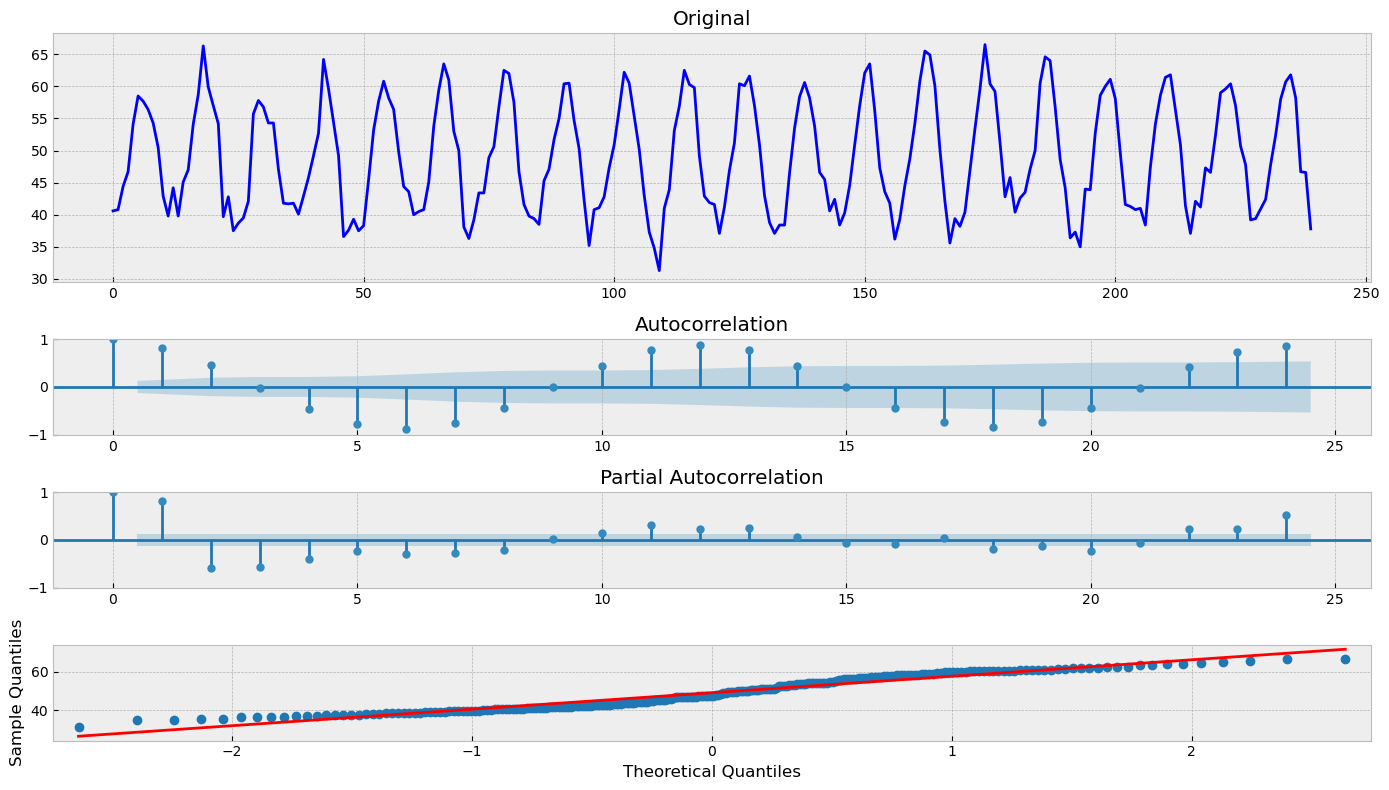

In [7]:
tsplot(series)

In [8]:
stat_series = series.copy()

In [9]:
stat_series = boxcox(stat_series, 0)
stat_series = np.diff(stat_series, 2)

Results of Dickey-Fuller Test:
Test Statistic                -1.040810e+01
p-value                        1.834221e-18
#Lags Used                     1.500000e+01
Number of Observations Used    2.220000e+02
Critical Value (1%)           -3.460154e+00
Critical Value (5%)           -2.874649e+00
Critical Value (10%)          -2.573757e+00
dtype: float64


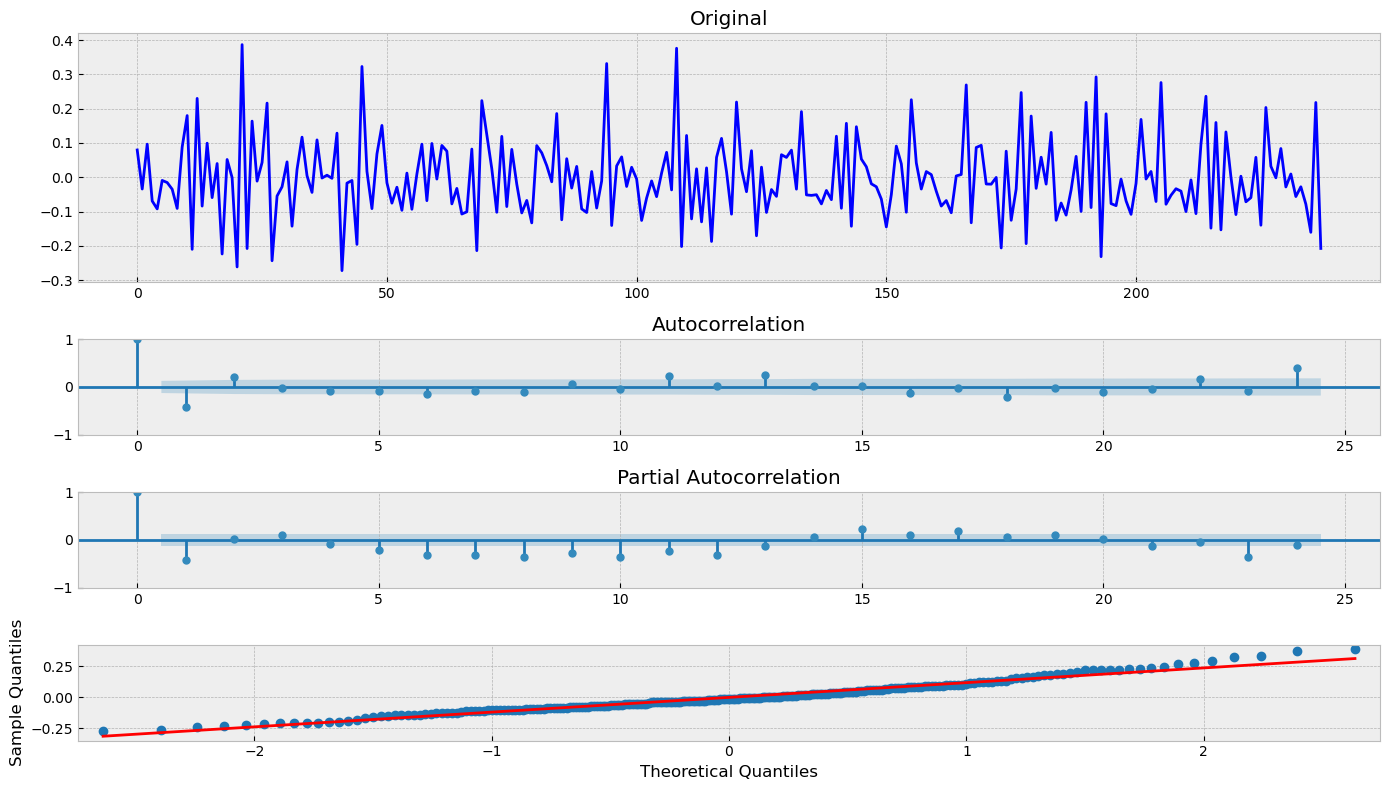

In [10]:
tsplot(stat_series)

## ARMA(p,q)
Модель ARMA(p, q) представляет собой соединение двух моделей:
- AR(P) - авторегрессии на знанениях временного ряда
- MA(q) - авторегрессии на ошибках первой

AR(p) пытается предсказать "значение" временного ряда, а MA(q) пытается поймать шоковые явления, наблюдаемые в оставшемся случайном шуме.

$y_t = \sum_{i=1}^P a_i x_{t-i} + \sum_{i=1}^Q b_i \epsilon_{t-i} + \epsilon_t + c$

## ARIMA(p,d,q)
ARIMA - естественное расширение модели ARMA. Многие временные ряды нестационарны, но они могут такими стать в результате операции дифференцирования. В модели ARIMA "дифференцирование" (в количестве d-раз) вносится в саму модель


$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$

### ARIMA с нестационарным рядом

In [11]:
def get_best_model(series):
    best_aic = np.inf
    best_order = None
    best_mdl = None
    
    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit()
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    
    
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

In [12]:
aic, order, mdl = get_best_model(series)

aic: 1136.18062 | order: (3, 0, 2)


In [13]:
mdl.params

const     49.030682
ar.L1      2.022922
ar.L2     -1.502603
ar.L3      0.290066
ma.L1     -1.746194
ma.L2      0.999677
sigma2     5.857725
dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                  -5.617137
p-value                          0.000001
#Lags Used                       5.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


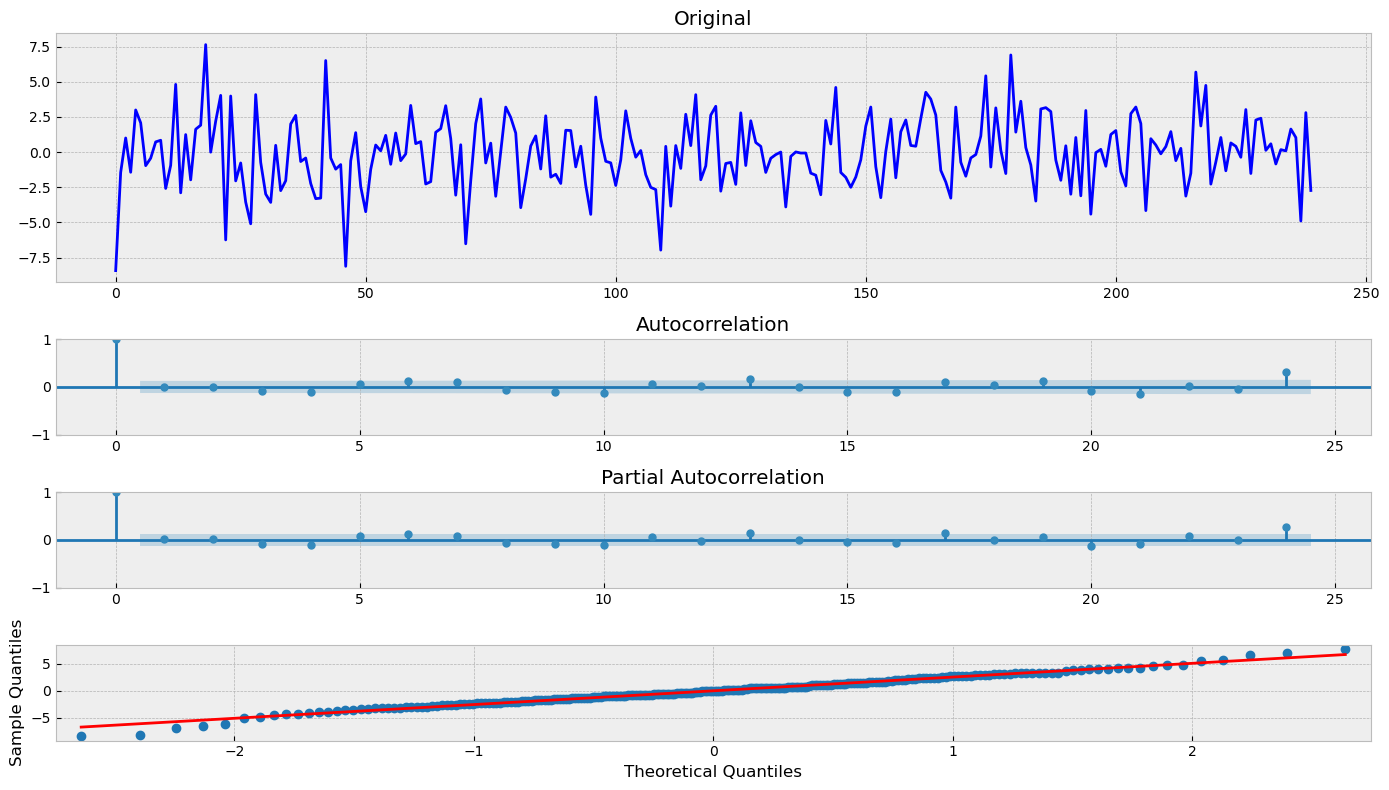

In [16]:
tsplot(mdl.resid)

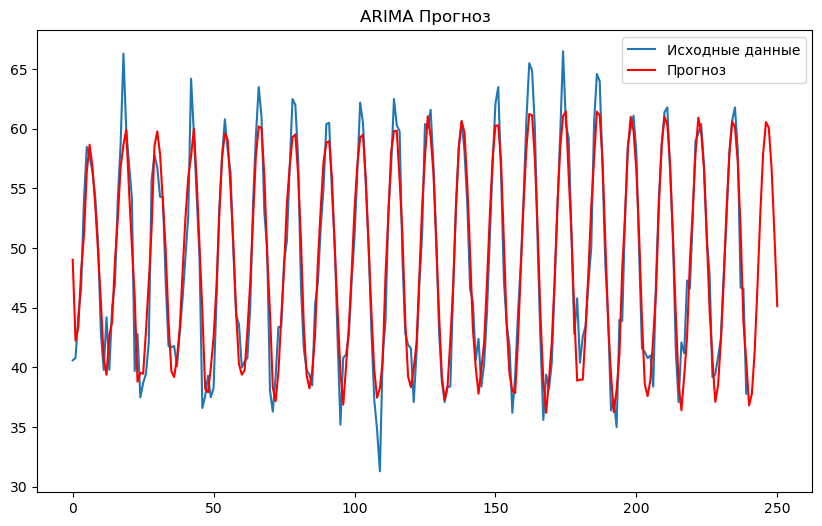

In [17]:
def plot_arima_model(series, best_mdl, n_steps=10):
    
    pred = best_mdl.get_prediction(start=0, end=len(series) + n_steps)
    pred_mean = pred.predicted_mean
    pred_ci = pred.conf_int()

    plt.figure(figsize=(10, 6))
    plt.plot(series, label='Исходные данные')

    plt.plot(pred_mean, color='red', label='Прогноз')
    # plt.plot(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='red')
    # plt.plot(pred,label='Исходные данные' )


    plt.title('ARIMA Прогноз')
    plt.legend()
    plt.show()

plot_arima_model(series, mdl)

### ARIMA со стационарным рядом

In [18]:
s_aic, s_order, s_mdl = get_best_model(stat_series)

aic: -497.42878 | order: (4, 0, 3)


Results of Dickey-Fuller Test:
Test Statistic                  -4.704987
p-value                          0.000082
#Lags Used                      13.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


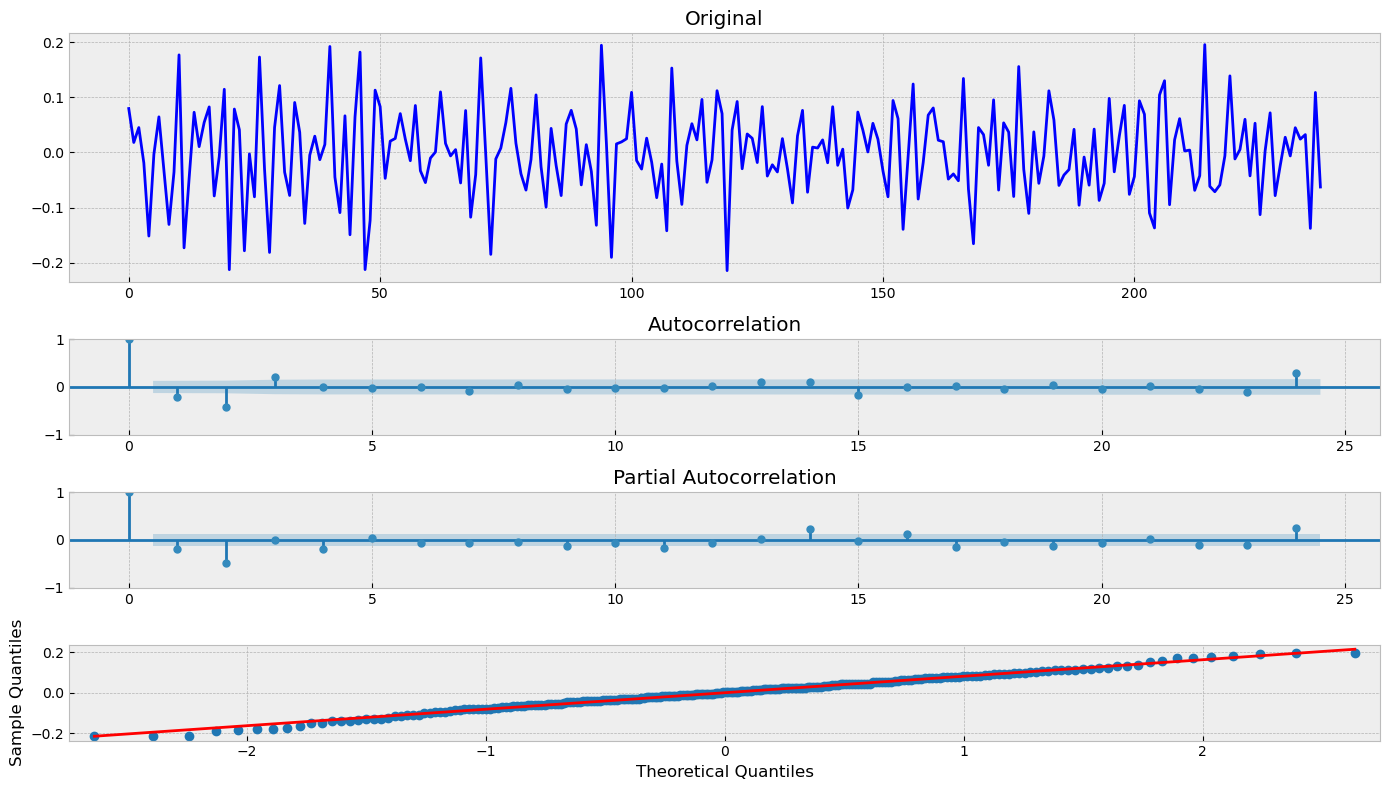

In [19]:
tsplot(s_mdl.resid)

Не намного лучше, так что продолжим работать с нестационарным рядом для предсказания будущих значений

In [20]:
train = series[:int(len(series) * 0.8)]
test = series[int(len(series) * 0.8):]

In [21]:
model = smt.ARIMA(train, order=order)
model_fit = model.fit()

In [22]:
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

In [23]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test, predictions)
print(f'Test MSE: {mse:.3f}')

Test MSE: 5.096


In [24]:
forecast = model_fit.forecast(steps=50)

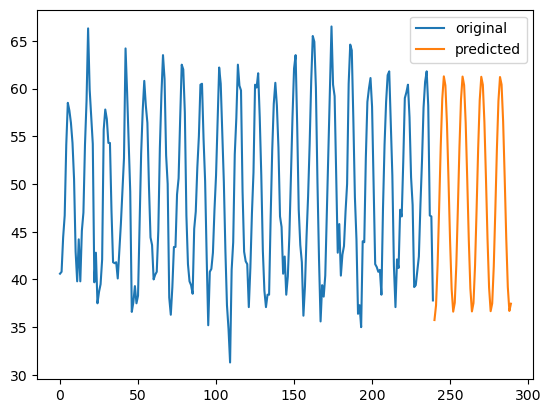

In [25]:
plt.plot(series, label='original')
plt.plot(pd.RangeIndex(start=len(series), stop=len(series)+len(forecast)), forecast, label='predicted')
plt.legend()
plt.show()

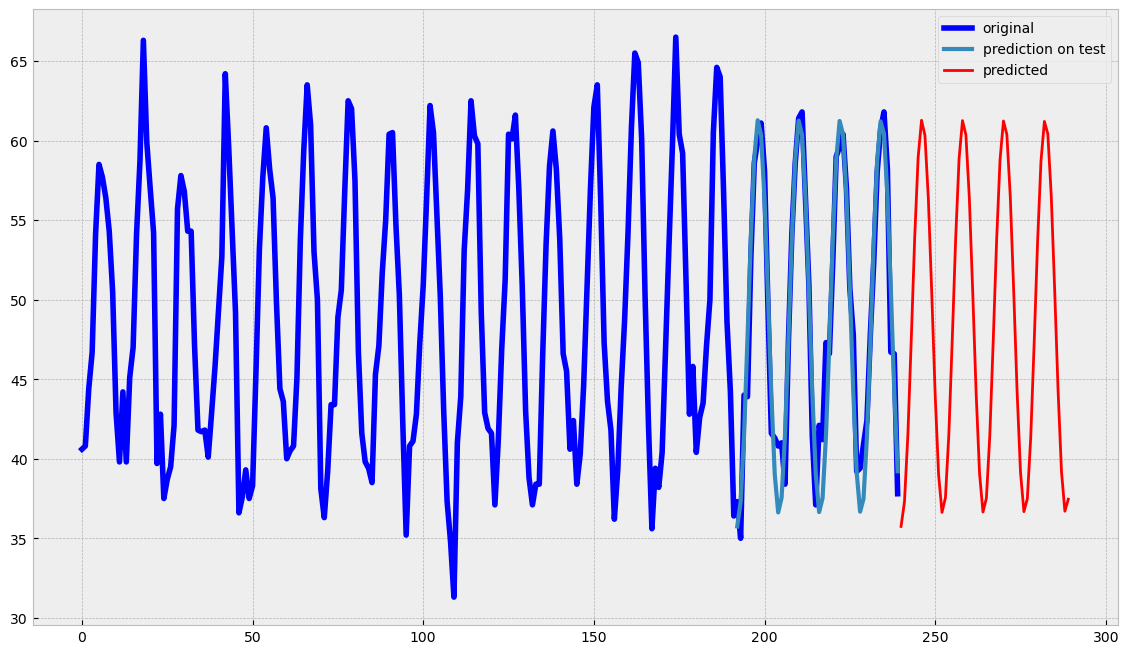

In [26]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, linewidth='4', color='blue', label='original')
    plt.plot(predictions, linewidth='3', label='prediction on test')
    plt.plot(pd.RangeIndex(start=len(series), stop=len(series)+len(forecast)), forecast, label='predicted', color='red', linewidth='2')
    plt.legend()